MCEq is a matrix-based fast cosmic ray flux calculator.

In [2]:
import numpy as np
import matplotlib as mpl
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from MCEq.core import MCEqRun
from MCEq.geometry.density_profiles import EarthsAtmosphere
import crflux.models as crf
import corsika
import datetime

# My Atmospheres
I have already tabulated a bunch of atmospheres for CORSIKA simulation. The MCEq atmosphere abstraction is simple enough to wrap my models.


In [3]:
class FFAtmosphere(corsika.Atmosphere):
    """
    From ForeFlight winds aloft data
    """
    def __init__(self, alt, temp, wa, inHg=29.92, h=None):
        super().__init__(h=h, SLP=inHg/29.92*101325)
        # Unit of station altitude is feet(!!)
        self.alt = alt
        iw0 = int(self.alt / 3000.0) + 1
        # Units of h_s is feet
        h_s = np.concatenate((np.array((0, alt), 'd'), np.arange(iw0, 19)*3000.0,
                              np.array((20000, 32000, 47000, 51000, 71000, 85000, 200000), 'd') * 3.28))
        T_s = np.concatenate((np.array((temp+0.001982*alt, temp)), wa,
                              np.array((-56.5, -44.5, -2.5, -2.5, -58.5, -86.3, 1000)))) + 273.16
        self.T_int = interp1d(h_s/3.28, T_s)

    def temperature(self, h):
        return self.T_int(h)

h = np.concatenate((np.arange(0, 30000, 1000), np.arange(30000, 50000, 2500), 
                np.arange(50000, 100000, 5000)))

atms = (
    (20, "ISA", datetime.datetime(1970, 1, 1, 0), 
     "International Standard Atmosphere",
     corsika.ISA(h)),

    (21, "KMCI", datetime.datetime(2023, 11, 20, 9), 
     "Atmosphere as predicted 3:00 am CST Nov 20 2023 over Kansas City (KMCI)",
     FFAtmosphere(h=h, alt=1027., temp=9., inHg=29.91, wa=np.array((
         3,   1,  -2,  -5, -10, -16, -23, -31, -38, 
         -47, -52, -51, -48, -49, -51, -53, -54, -56)))),
    
    (22, "KMSN", datetime.datetime(2020, 7,7), 
     "Atmosphere over MSN 07/07/2020",
     FFAtmosphere(h=h, alt=928., temp=26., inHg=29.97, wa=np.array((
         22,  16,   9,   3,  -2,  -7, -13, -19, -26, 
         -32, -40, -46, -51, -56, -61, -63, -65, -65)))),

    (23, "KMDT", datetime.datetime(2023, 11, 21, 23), 
     "Atmosphere over Harrisburg, PA on Nov 21 2023",
     FFAtmosphere(h=h, alt=310., temp=7., inHg=30.07, wa=np.array((
         5,   4,   0,  -3,  -7, -13, -19, -26, -33,
         -42, -49, -56, -60, -60, -59, -59, -59, -59)))),
    
    (24, "KLRD", datetime.datetime(2023, 11, 22, 13), 
     "Laredo, TX Nov 22 2023 1300Z",
     FFAtmosphere(h=h, alt=508., temp=6.,inHg=30.36, wa=np.array((
         6, 3, 2, -1, -6, -11, -18, -25, -31, -38,
         -43, -50, -56, -57, -59, -62, -65, -67)))),
                   
    (25, "KICT", datetime.datetime(2023, 11, 25, 21),
     "Wichita, TX Nov 25 2023 2100Z",
     FFAtmosphere(h=h, alt=1333., temp=-2., inHg=30.23, wa=np.array((
         -3, -2, -4, -7, -13, -19, -26, -34, -40, -47, 
         -50, -51, -51, -53, -55, -57, -59, -61)))),

    (26, "CYBC", datetime.datetime(2023, 11, 27, 17, 30),
     "Baie-Comeau, CA Nov 27 2023 1730Z",
     FFAtmosphere(h=h, alt=71, temp=1.0, inHg=29.48, wa=np.array((
         -2, -7, -8, -10, -16, -21, -28, -37, -44, -48, 
         -54, -55, -53, -53, -53, -54, -55, -56)))),

    (27, "KEYW", datetime.datetime(2023, 11, 28, 3), 
     "Key West, FL Nov 28 2023 0300Z",
     FFAtmosphere(h=h, alt=3, temp=24., inHg=30.08, wa=np.array((
         17, 14, 10, 4, 0, -6, -11, -18, -25, -32, -39, 
         -47, -55, -61, -67, -71, -74, -76)))),

    (28, "CYQT", datetime.datetime(2023, 12, 5, 17),
     "Thunder Bay, ON Dec 05 2023 1700Z",
     FFAtmosphere(h=h, alt=654, temp=1., inHg=30.05, wa=np.array((
         -4, -9, -14, -19, -25, -31, -37, -43, -49, -52, 
         -52, -51, -51, -51, -51, -51, -50, -51
     ))))
)

isa = atms[0][4]

In [4]:
class Atmosphere(EarthsAtmosphere):
    def __init__(self, *args, **kwargs):
        super().__init__(self, args, kwargs)
        m = kwargs['model']
        self._model = m

        self._rho_i = interp1d(m.h, m.density, bounds_error=False, fill_value=(2.50, 1E-09))

    def get_density(self, h_cm):
        z = h_cm * 0.01
        return self._rho_i(z) * 0.001
        

Instantiate a solver.

In [5]:
mceq = MCEqRun(

    # High-energy hadronic interaction model
    interaction_model='SIBYLL23C',

    # cosmic ray flux at the top of the atmosphere
    primary_model = (crf.HillasGaisser2012, 'H3a'),

    # zenith angle
    theta_deg = 0.
)


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [27]:
s_m = []
for bern, st_id, dt, desc, model in atms:
    print('Atmosphere model: ', st_id)
    atm = Atmosphere(model=model)
    mceq.set_density_model(atm)
    s_t = []
    for it, theta in enumerate(np.arange(0, 90, 10, dtype='d')):
        mceq.set_theta_deg(theta)
        print(f' - Theta: {theta:4.1f}°')
        mceq.solve()
        s_t.append(np.array(
            mceq.get_solution('mu-') +
            mceq.get_solution('mu+')))
    s_t = np.stack(s_t)
    s_m.append(s_t)
s_m = np.stack(s_m)

Atmosphere model:  ISA
 - Theta:  0.0°
 - Theta: 10.0°
 - Theta: 20.0°
 - Theta: 30.0°
 - Theta: 40.0°
 - Theta: 50.0°
 - Theta: 60.0°
 - Theta: 70.0°
 - Theta: 80.0°
Atmosphere model:  KMCI
 - Theta:  0.0°
 - Theta: 10.0°
 - Theta: 20.0°
 - Theta: 30.0°
 - Theta: 40.0°
 - Theta: 50.0°
 - Theta: 60.0°
 - Theta: 70.0°
 - Theta: 80.0°
Atmosphere model:  KMSN
 - Theta:  0.0°
 - Theta: 10.0°
 - Theta: 20.0°
 - Theta: 30.0°
 - Theta: 40.0°
 - Theta: 50.0°
 - Theta: 60.0°
 - Theta: 70.0°
 - Theta: 80.0°
Atmosphere model:  KMDT
 - Theta:  0.0°
 - Theta: 10.0°
 - Theta: 20.0°
 - Theta: 30.0°
 - Theta: 40.0°
 - Theta: 50.0°
 - Theta: 60.0°
 - Theta: 70.0°
 - Theta: 80.0°
Atmosphere model:  KLRD
 - Theta:  0.0°
 - Theta: 10.0°
 - Theta: 20.0°
 - Theta: 30.0°
 - Theta: 40.0°
 - Theta: 50.0°
 - Theta: 60.0°
 - Theta: 70.0°
 - Theta: 80.0°
Atmosphere model:  KICT
 - Theta:  0.0°
 - Theta: 10.0°
 - Theta: 20.0°
 - Theta: 30.0°
 - Theta: 40.0°
 - Theta: 50.0°
 - Theta: 60.0°
 - Theta: 70.0°
 - Theta:

In [28]:
s_m.shape

(9, 9, 121)

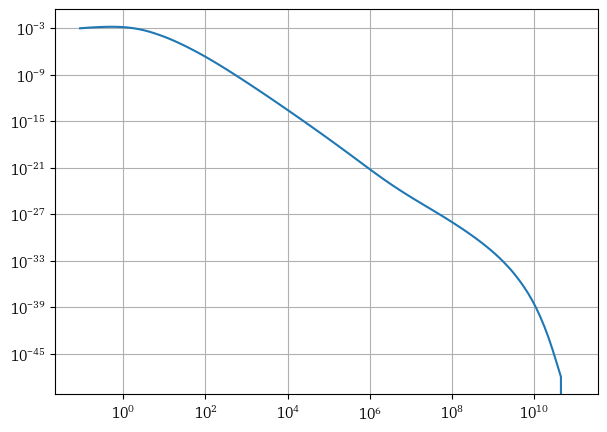

In [19]:
plt.loglog(mceq.e_grid,s_m[0,0])

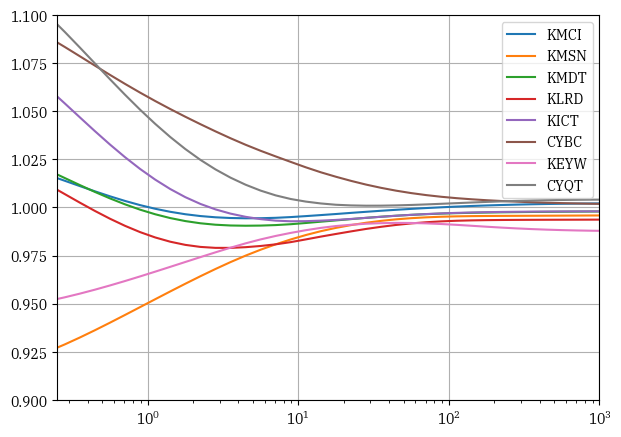

In [52]:
for i in range(1,9):
    plt.semilogx(mceq.e_grid, s_m[i,7] / s_m[0,7], label=atms[i][1])
plt.xlim(0.25, 1000)
plt.ylim(0.9, 1.1)
plt.legend()

In [26]:
mceq.e_grid[5:50:5]

array([2.81838293e-01, 8.91250938e-01, 2.81838293e+00, 8.91250938e+00,
       2.81838293e+01, 8.91250938e+01, 2.81838293e+02, 8.91250938e+02,
       2.81838293e+03])

In [41]:
st_id

'CYQT'

In [55]:
atm.set_theta(0)

In [43]:
atmX = Atmosphere(model=atms[7][4])

In [57]:
atm.max_X

1039.3572744156

In [45]:
atmX.set_theta(60)

In [48]:
mceq.get_solution('mu-')

array([ 8.25749097e-07,  9.33411778e-07,  1.05302804e-06,  1.18133408e-06,
        1.32051562e-06,  1.47229805e-06,  1.63684217e-06,  1.81045340e-06,
        1.99391413e-06,  2.18375967e-06,  2.37634973e-06,  2.56508616e-06,
        2.74412033e-06,  2.90146469e-06,  3.02824614e-06,  3.10984721e-06,
        3.13493502e-06,  3.09161307e-06,  2.97448985e-06,  2.78845634e-06,
        2.53399315e-06,  2.22246336e-06,  1.87430524e-06,  1.51787672e-06,
        1.17878177e-06,  8.77580673e-07,  6.27076536e-07,  4.30702218e-07,
        2.85111565e-07,  1.82189117e-07,  1.12568701e-07,  6.73808180e-08,
        3.91138602e-08,  2.20852811e-08,  1.21541081e-08,  6.53154337e-09,
        3.43278381e-09,  1.76558458e-09,  8.90549016e-10,  4.41114523e-10,
        2.14762543e-10,  1.02911575e-10,  4.86228833e-11,  2.26959714e-11,
        1.04734489e-11,  4.78489782e-12,  2.16666512e-12,  9.72992404e-13,
        4.33466614e-13,  1.91601466e-13,  8.41459689e-14,  3.66874241e-14,
        1.59018400e-14,  

In [53]:
station_code = "USM00072645" # GREEN BAY from igra2-station-list.txt